### Paxillin movie segmentation and object feature analysis

with Shailaja's movies

Liya Ding, 2024.03

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import umap
from joblib import dump, load
import os.path

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.transforms import Bbox

import tifffile 
import czifile

import skimage
from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb

from scipy import ndimage
from scipy import ndimage as ndi
from scipy.ndimage import distance_transform_cdt
from scipy.ndimage import gaussian_filter


from skimage.color import label2rgb
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)

from skimage.morphology import binary_opening, binary_dilation
from skimage.morphology import disk



from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# function from aicssegmentation tool
from utils.vessel_2d import filament_2d_wrapper
from utils.pre_processing_utils import intensity_normalization


In [2]:
czimovie_dir =  '/mnt/d/lding/FA/data/FHL2_movies_Shailaja_20231215'


csv_output_dir = '/mnt/d/lding/FA/analysis_results/movies_SS/vess_LoThr_Dot_less_csv'
plot_output_dir = '/mnt/d/lding/FA/analysis_results/movies_SS/vess_LoThr_Dot_less_FA_plot'
seg_output_dir = '/mnt/d/lding/FA/analysis_results/movies_SS/vess_LoThr_Dot_less_FA_seg'

if not os.path.isdir(csv_output_dir):
    os.makedirs(csv_output_dir)
if not os.path.isdir(plot_output_dir):
    os.makedirs(plot_output_dir)
if not os.path.isdir(seg_output_dir):
    os.makedirs(seg_output_dir)

In [3]:
# build the colormap with iterative tab20
tab20 = cm.get_cmap('tab20', 20)
for i in range(10):
    tab20.colors = np.concatenate([tab20.colors,tab20.colors],axis=0)    
tab20.colors = np.concatenate([np.zeros([1,4]),tab20.colors],axis=0)
# print(tab20.colors)


newmap = cm.get_cmap('tab20', 4000+1)
newmap.colors = tab20.colors[0:4000+1,:]
newmap.colors[0,:]  = np.zeros([1,4])
newmap.colors[0,3] = 1


In [4]:
tab20.colors.shape

(20481, 4)

### for each movie run through all the time points

In [5]:
# flag for some optinal parts
flag_plot = True
flag_plot_save = True
flag_seg_save = True
flag_csv_save = True
flag_run_all = False
flag_panel_plot = True

/home/ldin/anaconda3/envs/segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:64: FutureWarning: in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
/home/ldin/anaconda3/envs/segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:90: FutureWarning: in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
/home/ldin/anaconda3/envs/segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:98: FutureWarning: in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argumen

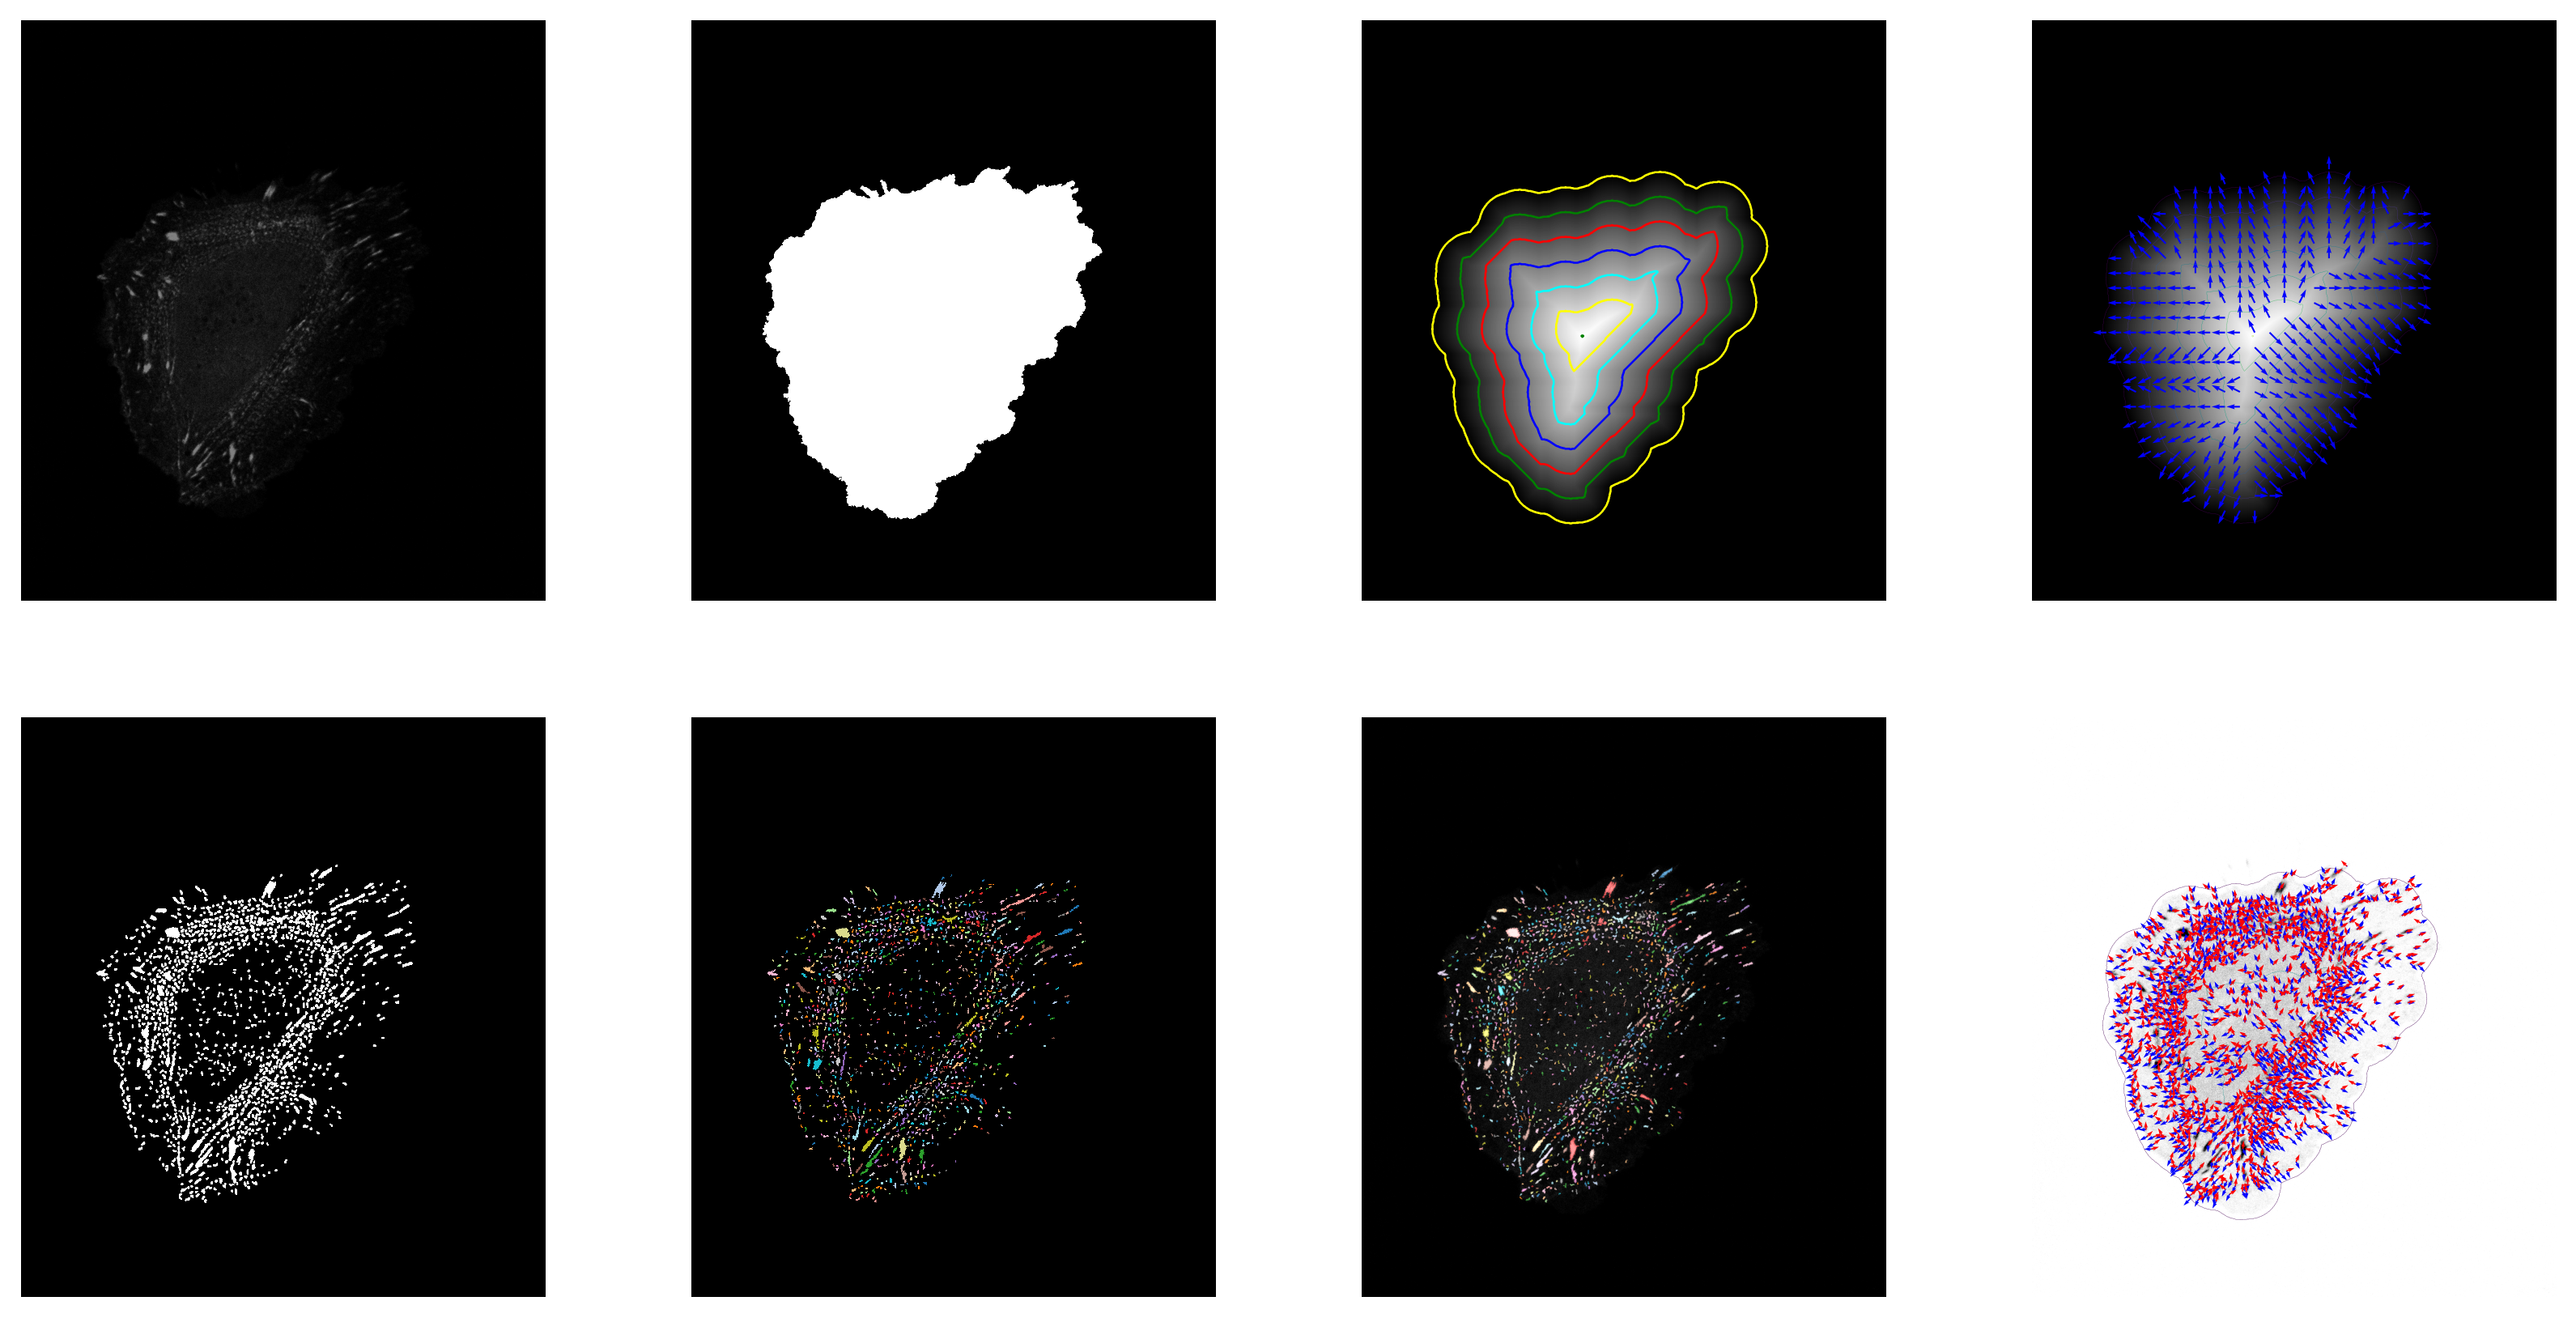

In [12]:
filenames = [x for x in os.listdir(czimovie_dir) if os.path.isfile(os.path.join(czimovie_dir, x)) and ('.czi' in x)]

# if not in run all mode, only test with the first image of the first movie
if not flag_run_all:
    filenames = filenames[0:1]

for filenameID in range(len(filenames)):

 ### for each movie, make sub-folders for different output for easier viewing in imagej
    movie_labeltoggle_output_dir = os.path.join(seg_output_dir,  'labeltoggle'+str(filenameID))
    movie_mask_output_dir = os.path.join(seg_output_dir,  'mask'+str(filenameID))
    movie_seg_output_dir = os.path.join(seg_output_dir,  'seg'+str(filenameID))
    movie_label_output_dir = os.path.join(seg_output_dir,  'label'+str(filenameID))
    movie_rgb_output_dir = os.path.join(seg_output_dir,  'rgb'+str(filenameID))   

    movie_contour_output_dir = os.path.join(plot_output_dir,  'contour_'+str(filenameID))
    movie_quiver_cell_output_dir = os.path.join(plot_output_dir,  'quiver_cell_'+str(filenameID))
    movie_quiver_obj_output_dir = os.path.join(plot_output_dir,  'quiver_obj_'+str(filenameID))
    movie_label_color_output_dir = os.path.join(plot_output_dir,  'label_color_'+str(filenameID))
    movie_rgb_plot_output_dir = os.path.join(plot_output_dir,  'rgb_plot'+str(filenameID))
    movie_panels_plot_output_dir = os.path.join(plot_output_dir,  'panel_plot'+str(filenameID))   
    

    
    if not os.path.isdir(movie_mask_output_dir):          os.makedirs(movie_mask_output_dir)
    if not os.path.isdir(movie_seg_output_dir):           os.makedirs(movie_seg_output_dir)
    if not os.path.isdir(movie_label_output_dir):         os.makedirs(movie_label_output_dir)
    if not os.path.isdir(movie_rgb_output_dir):           os.makedirs(movie_rgb_output_dir)
    if not os.path.isdir(movie_contour_output_dir):       os.makedirs(movie_contour_output_dir)
    if not os.path.isdir(movie_quiver_cell_output_dir):   os.makedirs(movie_quiver_cell_output_dir)
    if not os.path.isdir(movie_quiver_obj_output_dir):    os.makedirs(movie_quiver_obj_output_dir)
    if not os.path.isdir(movie_label_color_output_dir):   os.makedirs(movie_label_color_output_dir)
    if not os.path.isdir(movie_rgb_plot_output_dir):      os.makedirs(movie_rgb_plot_output_dir)
    if not os.path.isdir(movie_panels_plot_output_dir):   os.makedirs(movie_panels_plot_output_dir)
    if not os.path.isdir(movie_labeltoggle_output_dir):   os.makedirs(movie_labeltoggle_output_dir)

    filename = filenames[filenameID]
    img = tifffile.imread(os.path.join(czimovie_dir,filename))
    ### intensity normalization
    intensity_scaling_param = [5,20]
    norm_pax_movie = intensity_normalization(img, scaling_param=intensity_scaling_param)
         
    # get the length is the movie
    time_length = img.shape[0]

    # if not in run all mode, only test with the first image of the first movie
    if not flag_run_all:
        time_length = 1

    # for timeID in range(time_length):
    for timeID in range(2,3):

        prop_df_pax = pd.DataFrame(columns=['filename','cell_ID','time_point','pixel_size','area', 'bbox_area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number',
                            'extent','filled_area','label','major_axis_length','max_intensity','mean_intensity',
                            'min_intensity','minor_axis_length','orientation','perimeter','solidity',
                            'cell_edge_dist','cell_edge_orient','diff_orient'])


        input_pax_img = norm_pax_movie[timeID,:,:]      
        smooth_pax_img = gaussian_filter(input_pax_img,sigma=1,mode='nearest',truncate=3)
        ### low threshold to get cell masks
        new_cell_mask = smooth_pax_img>0.01
        ### remove isolated small objects (small regions due to noise)
        new_cell_mask = remove_small_objects(new_cell_mask>0, min_size=10000, connectivity=1, in_place=False)        
        # remove holes
        new_cell_mask = ndimage.binary_fill_holes(new_cell_mask)
        # calculate the distance map
        distance_taxicab = distance_transform_cdt(new_cell_mask, metric="taxicab")
        
        ## PARAMETERS for vesselness filter step ##
        f2_param = [[1, 0.75]]
        pax_seg = filament_2d_wrapper(smooth_pax_img, f2_param)


        no_back_smooth_MIP_pax_img = input_pax_img.copy()
        no_back_smooth_MIP_pax_img[new_cell_mask==0] = np.mean(smooth_pax_img[new_cell_mask==1])
        thresh_sauvola = threshold_sauvola(no_back_smooth_MIP_pax_img, window_size=201,k=-1.75)
        binary_sauvola = input_pax_img > thresh_sauvola


        f2_param = [[2, 0.85]]
        pax_res_2 = filament_2d_wrapper(smooth_pax_img, f2_param)

        f2_param = [[1, 0.75]]
        pax_res_1 = filament_2d_wrapper(smooth_pax_img, f2_param)

        pax_seg_1 = pax_res_1 > 0.75
        pax_seg_2 = pax_res_2 > 0.85

        binary_sauvola = remove_small_objects(binary_sauvola>0, min_size=3, connectivity=1, in_place=False)


        log_sigma = 1

        responce = -1*(log_sigma**2)*ndi.filters.gaussian_laplace(smooth_pax_img, log_sigma)
        
        pax_seg_dot = responce  > 0.012
        pax_seg_dot = remove_small_objects(pax_seg_dot>0, min_size=3, connectivity=1, in_place=False)

        pax_seg = (pax_seg_dot + pax_seg_1 + pax_seg_2 + binary_sauvola)>0    

        # remove segmentation outside of the cell
        pax_seg = pax_seg*new_cell_mask
        # remove single pixel objects
        pax_seg = remove_small_objects(pax_seg>0, min_size=10, connectivity=1, in_place=False)

        # label segmentations and calculate the region properties
        label_pax_seg = label(pax_seg)
        regionprops_pax = regionprops(label_pax_seg,intensity_image=input_pax_img)
        
        # prepare the color map with max of the labels for display (consistent through all images)
        max_label = label_pax_seg.max()
        newmap = cm.get_cmap('tab20', max_label+1)
        newmap.colors = tab20.colors[0:max_label+1,:]
        newmap.colors[0,:]  = np.zeros([1,4])
        newmap.colors[0,3] = 1
        pax_image_label_overlay = label2rgb(label_pax_seg, image=input_pax_img*2,kind='overlay',alpha=0.75,colors=newmap.colors)
        

        for_orent_mask = binary_opening(new_cell_mask, disk(51))
        for_orent_mask = binary_dilation(for_orent_mask, disk(11))
        for_orent_distance_taxicab = distance_transform_cdt(for_orent_mask, metric="taxicab")    
        
        bigger_for_orent_mask = binary_dilation(for_orent_mask, disk(11))
        bigger_for_orent_distance_taxicab = distance_transform_cdt(bigger_for_orent_mask, metric="taxicab")


        # obtain cell edge orientation based on gradient of the distance map    
        n_v = skimage.filters.sobel_v(bigger_for_orent_distance_taxicab)
        n_h = skimage.filters.sobel_h(bigger_for_orent_distance_taxicab)
        # somehow the gradients are really small, make them reasonable values
        for_plot_max = 5/min(n_v.max(), n_h.max())
        n_v = n_v*for_plot_max
        n_h = n_h*for_plot_max
                
        # convert the directions into orientation angels   
        local_orientation = np.arctan2(n_v,n_h)

        # find the orentation and directional vectors for each object at the centroid        
        # initialize the vectors
        obj_X = np.zeros([label_pax_seg.max(),1])
        obj_Y = np.zeros([label_pax_seg.max(),1])
        cell_U = np.zeros([label_pax_seg.max(),1])
        cell_V = np.zeros([label_pax_seg.max(),1])
        obj_U = np.zeros([label_pax_seg.max(),1])
        obj_V = np.zeros([label_pax_seg.max(),1])
        cell_tan_U = np.zeros([label_pax_seg.max(),1])
        cell_tan_V = np.zeros([label_pax_seg.max(),1])
        
        for iL in range(label_pax_seg.max()):  
            obj_X[iL] = regionprops_pax[iL]['centroid'][0]
            obj_Y[iL] = regionprops_pax[iL]['centroid'][1]

            obj_U[iL] = np.sin(regionprops_pax[iL]['orientation'])
            obj_V[iL] = np.cos(regionprops_pax[iL]['orientation'])

            cell_edge_orient = local_orientation[int(obj_X[iL]),int(obj_Y[iL])]
            cell_tan_U[iL] = np.sin(cell_edge_orient)
            cell_tan_V[iL] = np.cos(cell_edge_orient)
            
            cell_U[iL] = n_v[int(obj_X[iL]),int(obj_Y[iL])]
            cell_V[iL] = n_h[int(obj_X[iL]),int(obj_Y[iL])]

            diff_orient = cell_edge_orient - regionprops_pax[iL]['orientation']

            if(diff_orient>np.pi/2):       diff_orient = diff_orient - np.pi
            if(diff_orient>np.pi/2):       diff_orient = diff_orient - np.pi
            if(diff_orient<-np.pi/2):      diff_orient = diff_orient + np.pi
            if(diff_orient<-np.pi/2):      diff_orient = diff_orient + np.pi

            diff_orient = np.abs(diff_orient)   

            cell_edge_dist = distance_taxicab[int(obj_X[iL]),int(obj_Y[iL])]
            pixel_size=0.0775
            # append the feature properties and add the distance and orientation features         
            s = pd.Series([filename, filenameID, timeID, pixel_size,
                           regionprops_pax[iL].area,regionprops_pax[iL].bbox_area,regionprops_pax[iL].convex_area,
                           regionprops_pax[iL].eccentricity,regionprops_pax[iL].equivalent_diameter,regionprops_pax[iL].euler_number,
                           regionprops_pax[iL].extent,regionprops_pax[iL].filled_area,regionprops_pax[iL].label,
                           regionprops_pax[iL].major_axis_length,regionprops_pax[iL].max_intensity,regionprops_pax[iL].mean_intensity,
                           regionprops_pax[iL].min_intensity,regionprops_pax[iL].minor_axis_length,regionprops_pax[iL].orientation,
                           regionprops_pax[iL].perimeter,regionprops_pax[iL].solidity, 
                           cell_edge_dist, cell_edge_orient,diff_orient],
                           index=['filename','cell_ID','time_point','pixel_size','area', 'bbox_area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number',
                                  'extent','filled_area','label','major_axis_length','max_intensity','mean_intensity',
                                  'min_intensity','minor_axis_length','orientation','perimeter','solidity',
                                  'cell_edge_dist','cell_edge_orient','diff_orient'])
            prop_df_pax = prop_df_pax.append(s,ignore_index=True)

        if flag_csv_save:
            prop_df_pax.to_csv(os.path.join(csv_output_dir,'labelprop_SS_'+str(filenameID)+'_t'+str(timeID)+'.csv'))

        if flag_seg_save:
            # tifffile.imsave(os.path.join(movie_labeltoggle_output_dir, 'SS_pax_img_'+filename+'_MIP'+'.tif'),input_pax_img.astype(np.float32))   
            tifffile.imsave(os.path.join(movie_mask_output_dir, 'SS_cell_mask_'+str(filenameID)+'_t'+str(timeID)+'.tif'),new_cell_mask.astype(np.uint8))   
            tifffile.imsave(os.path.join(movie_seg_output_dir, 'SS_pax_seg_'+str(filenameID)+'_t'+str(timeID)+'.tif'),pax_seg.astype(np.uint8))   
            tifffile.imsave(os.path.join(movie_label_output_dir, 'SS_pax_seglabel_'+str(filenameID)+'_t'+str(timeID)+'.tif'),label_pax_seg.astype(np.uint16))   
            tifffile.imsave(os.path.join(movie_rgb_output_dir, 'SS_pax_segrgb_'+str(filenameID)+'_t'+str(timeID)+'.jpg'),pax_image_label_overlay)   
        
        if flag_plot:

            if flag_panel_plot:
                # plot the main outputs together for quick viewing
                fig, ax = plt.subplots(2,4, figsize=(16,8), dpi=256, facecolor='w', edgecolor='k')
                ax[0,0].imshow(input_pax_img, cmap=plt.cm.gray,vmax=2,vmin=0)
                ax[0,0].axis('off')
                ax[0,1].imshow(new_cell_mask, cmap=plt.cm.gray,vmax=0.3,vmin=0)
                ax[0,1].axis('off')

                # build a grid for contour plot
                X, Y = np.meshgrid(np.arange(0,new_cell_mask.shape[1]), np.arange(0,new_cell_mask.shape[0]))
                ax[0,2].imshow(for_orent_distance_taxicab/(for_orent_distance_taxicab.max()),cmap=plt.cm.gray)
                ax[0,2].contour(X, Y, for_orent_distance_taxicab,6,colors=('yellow','green', 'r','blue','cyan'),linewidths=0.7)
                ax[0,2].axis('off')        
            
                # build a sparse grid and only within cell mask for quivering the directions
                grid_mask = np.zeros_like(new_cell_mask)
                grid_mask[::30,::30] = new_cell_mask[::30,::30]
                to_plot_X = X[grid_mask>0]
                to_plot_Y = Y[grid_mask>0]
                to_plot_U = n_v[grid_mask>0]
                to_plot_H = n_h[grid_mask>0]

                ax[0,3].imshow(for_orent_distance_taxicab,cmap=plt.cm.gray)
                ax[0,3].quiver(to_plot_X,to_plot_Y, -to_plot_U,to_plot_H,color='blue')
                ax[0,3].contour(X, Y, for_orent_distance_taxicab,6,linewidths=0.1)    
                ax[0,3].axis('off')


                ax[1,0].imshow(pax_seg, cmap=plt.cm.gray,vmax=0.1,vmin=0)
                ax[1,0].axis('off')
                
                ax[1,1].imshow(label_pax_seg, cmap=newmap,vmax = 4001,vmin = 0,interpolation='none')
                ax[1,1].axis('off')

                ax[1,2].imshow(pax_image_label_overlay)
                ax[1,2].axis('off')
                
                ax[1,3].imshow(1-input_pax_img,cmap=plt.cm.gray,vmax=1,vmin=0)
                # quiver the orientation based on cell shape in blue
                ax[1,3].quiver(obj_Y,obj_X, -cell_U,cell_V,color='blue')
                # quiver the orientation of each object in magenta        
                ax[1,3].quiver(obj_Y,obj_X,  -obj_U,obj_V,color='red')  
                ax[1,3].contour(X, Y, for_orent_distance_taxicab,1,linewidths=0.1)        
                ax[1,3].axis('off')

                if flag_plot_save: 
                    # save the plots and subplots for easier viewing
                    plt.savefig(os.path.join(movie_panels_plot_output_dir,'panels_'+str(filenameID)+'_t'+str(timeID)+'_org_sm_ves_seg.png'))

                    extent = ax[1,3].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
                    fig.savefig(os.path.join(movie_quiver_obj_output_dir,'quiver_obj_'+str(filenameID)+'_t'+str(timeID)+'.png'), bbox_inches=extent)

                    extent = ax[0,2].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
                    fig.savefig(os.path.join(movie_contour_output_dir,'contours_'+str(filenameID)+'_t'+str(timeID)+'.png'), bbox_inches=extent)

                    extent = ax[0,3].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
                    fig.savefig(os.path.join(movie_quiver_cell_output_dir,'quiver_cell_'+str(filenameID)+'_t'+str(timeID)+'.png'), bbox_inches=extent)

                    extent = ax[1,1].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
                    fig.savefig(os.path.join(movie_label_color_output_dir,'labels_'+str(filenameID)+'_t'+str(timeID)+'.png'), bbox_inches=extent)

                    extent = ax[1,2].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
                    fig.savefig(os.path.join(movie_rgb_plot_output_dir,'rgb_'+str(filenameID)+'_t'+str(timeID)+'.png'), bbox_inches=extent)
                
                if flag_run_all:
                    plt.close(fig) 
            else:
                # plot the the features for debugging
                plt.rcParams["figure.figsize"] = (30,30)
                plt.imshow(input_pax_img*1.5,cmap=plt.cm.gray,vmax=1,vmin=0)
                # plt.hold(True)
                # quiver the orientation based on cell shape in blue

                for iL in range(1,label_pax_seg.max()):  

                    obj_X[iL] = regionprops_pax[iL]['centroid'][0]
                    obj_Y[iL] = regionprops_pax[iL]['centroid'][1]

                    cell_edge_dist = distance_taxicab[int(obj_X[iL]),int(obj_Y[iL])]

                    obj_U[iL] = np.sin(regionprops_pax[iL]['orientation'])
                    obj_V[iL] = np.cos(regionprops_pax[iL]['orientation'])

                    cell_edge_orient = local_orientation[int(obj_X[iL]),int(obj_Y[iL])]
                    cell_tan_U[iL] = np.sin(cell_edge_orient)
                    cell_tan_V[iL] = np.cos(cell_edge_orient)
                    
                    cell_U[iL] = n_v[int(obj_X[iL]),int(obj_Y[iL])]
                    cell_V[iL] = n_h[int(obj_X[iL]),int(obj_Y[iL])]

                    diff_orient = cell_edge_orient - regionprops_pax[iL]['orientation']
                    if(diff_orient>np.pi/2):       diff_orient = diff_orient - np.pi
                    if(diff_orient>np.pi/2):       diff_orient = diff_orient - np.pi
                    if(diff_orient<-np.pi/2):      diff_orient = diff_orient + np.pi
                    if(diff_orient<-np.pi/2):      diff_orient = diff_orient + np.pi

                    diff_orient = np.abs(diff_orient)  
                    [px,py] =np.where(label_pax_seg==iL)
                    plt.plot(py,px,color=newmap.colors[iL,:])

                    # plt.text(obj_Y[iL],obj_X[iL],'d='+f'{cell_edge_dist:.0f}'+',oo='+f'{regionprops_pax[iL].orientation:.1f}'+',co='+f'{cell_edge_orient:.1f}'+',diff='+f'{diff_orient:.1f}',color='r')
                    plt.text(obj_Y[iL],obj_X[iL],'d'+f'{cell_edge_dist:.0f}'+',o'+f'{regionprops_pax[iL].orientation:.1f}'+',c'+f'{cell_edge_orient:.1f}'+',d'+f'{diff_orient:.1f}',color='r')
              
                plt.quiver(obj_Y,obj_X, -cell_U,cell_V,color='blue',width=0.001)
                # quiver the orientation of each object in magenta        
                plt.quiver(obj_Y,obj_X,  -obj_U,obj_V,color='m',width=0.001)   


              
                if flag_plot_save: 
                    # save the plots and subplots for easier viewing
                    plt.savefig(os.path.join(movie_panels_plot_output_dir,'features_'+str(filenameID)+'_t'+str(timeID)+'.png'))
                
                if flag_run_all:
                    plt.close(fig) 
                        

                

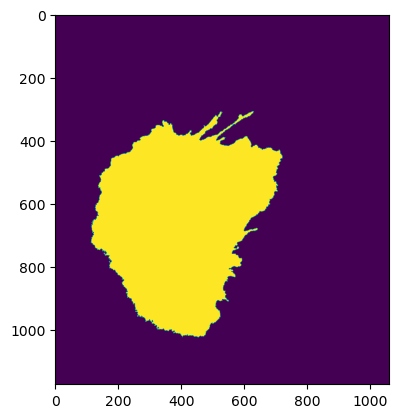

In [14]:
plt.imshow(new_cell_mask)

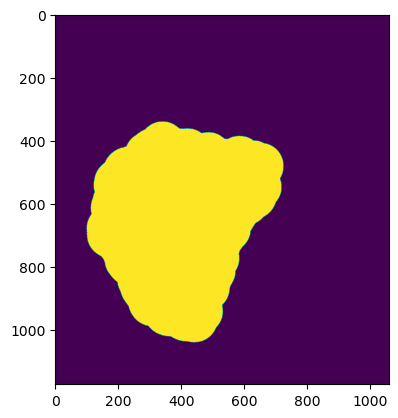

In [15]:
plt.imshow(for_orent_mask)

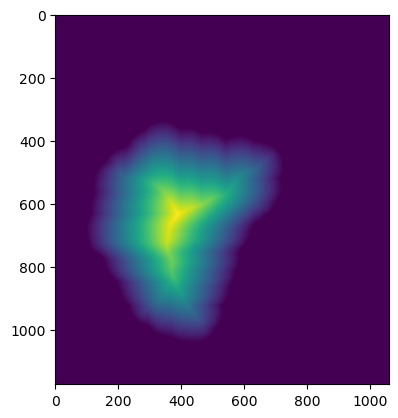

In [16]:
plt.imshow(for_orent_distance_taxicab)

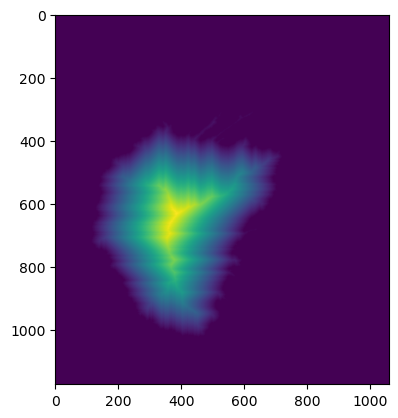

In [17]:
plt.imshow(distance_taxicab)

(-0.5, 1058.5, 1172.5, -0.5)

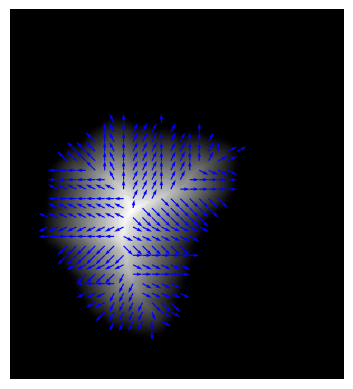

In [18]:
plt.imshow(for_orent_distance_taxicab,cmap=plt.cm.gray)
plt.quiver(to_plot_X,to_plot_Y, -to_plot_U,to_plot_H,color='blue')
plt.contour(X, Y, for_orent_distance_taxicab,6,linewidths=0.1)    
plt.axis('off')

In [19]:
'd='+f'{cell_edge_dist:.0f}'+',oo='+f'{regionprops_pax[iL].orientation:.1f}'+',co='+f'{cell_edge_orient:.1f}'+',diff='+f'{diff_orient:.1f}'

'd=6,oo=0.5,co=3.1,diff=0.5'

In [20]:
f'{cell_edge_dist:.0f}'

'6'

### belows are for debugging, keep it here until no longer needed

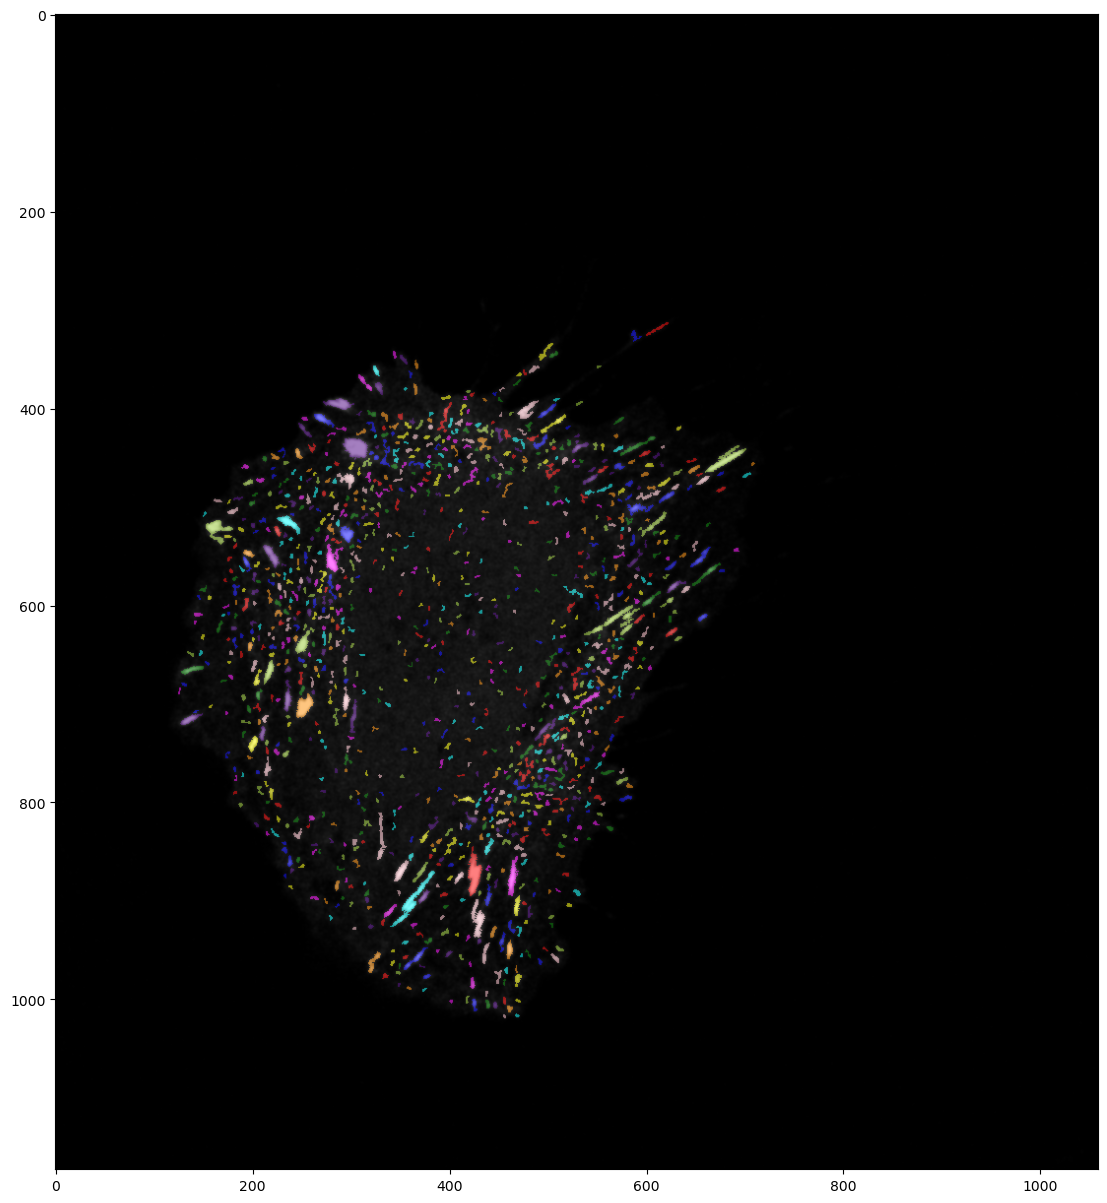

In [21]:
pax_image_label_overlay = label2rgb(label_pax_seg, image=smooth_pax_img, bg_label=0,kind='overlay',alpha=0.5)
plt.rcParams["figure.figsize"] = (15,15)
plt.imshow(pax_image_label_overlay)

(-0.5, 1058.5, 1172.5, -0.5)

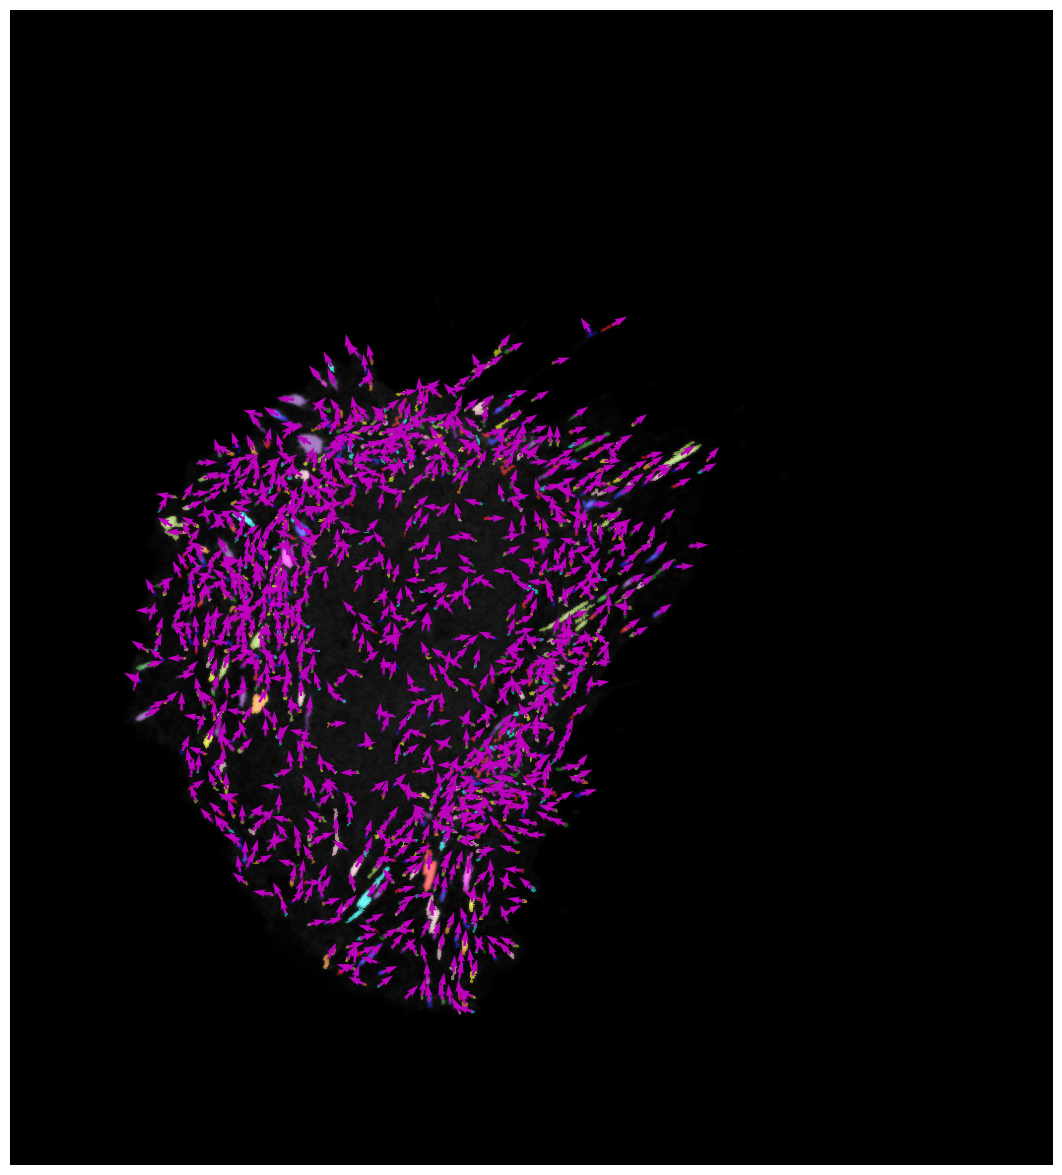

In [22]:
plt.rcParams["figure.figsize"] = (15,15)
plt.imshow(pax_image_label_overlay, cmap=plt.cm.RdBu_r,vmax=0.1,vmin=0)
# plt.quiver(obj_Y,obj_X, cell_U,cell_V,color='blue')
Q = plt.quiver(obj_Y,obj_X, -obj_U,obj_V,color='m')#width=0.005,headwidth=0.1,headaxislength=0.02,headlength=0.01)
# plt.quiver(obj_Y,obj_X, cell_U,cell_V,color='blue')

plt.axis('off')

(-0.5, 1058.5, 1172.5, -0.5)

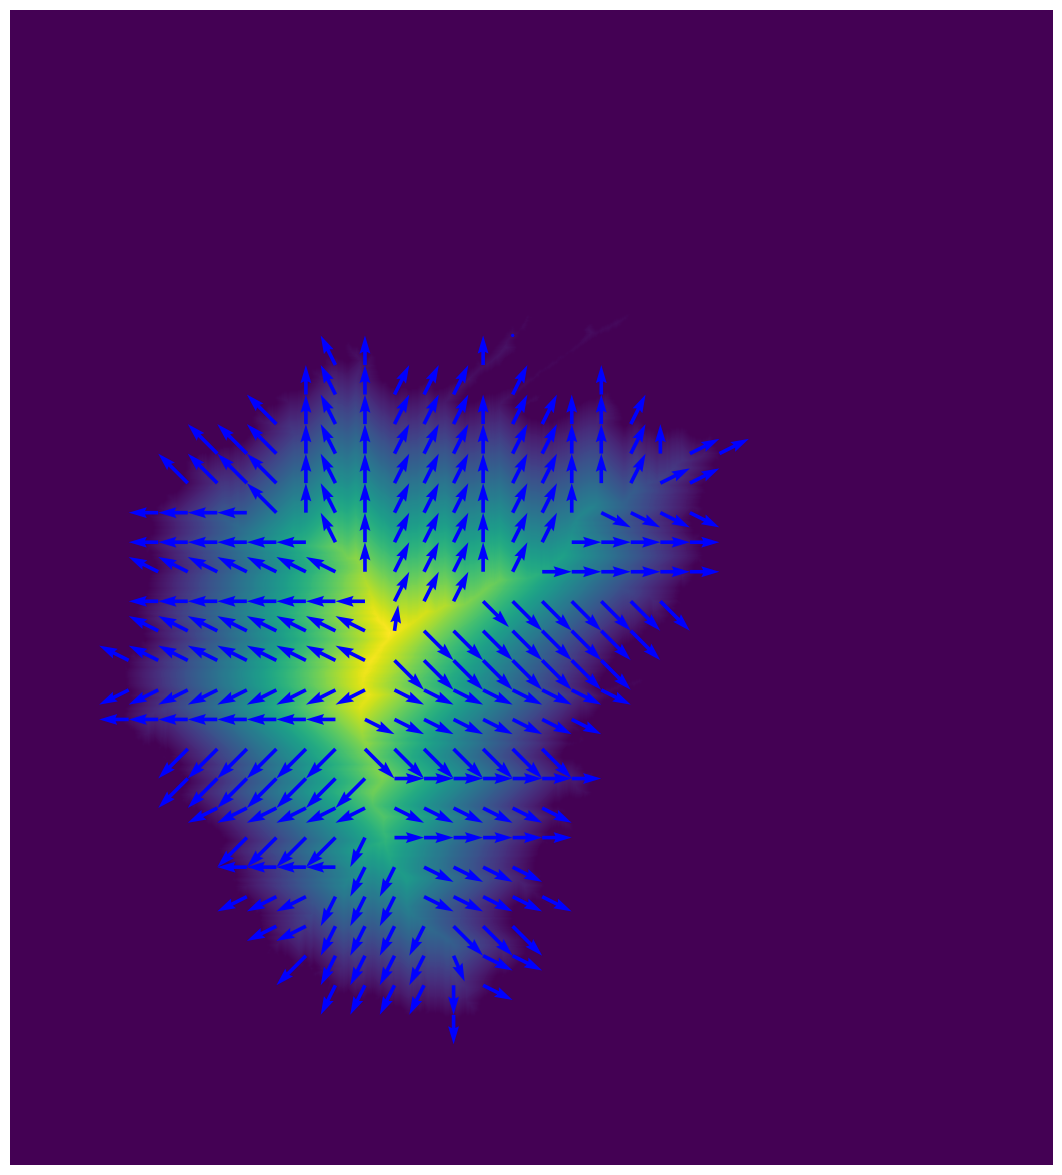

In [23]:
plt.imshow(distance_taxicab)

grid_mask = np.zeros_like(new_cell_mask)
grid_mask[::30,::30] = new_cell_mask[::30,::30]
to_plot_X = X[grid_mask>0]
to_plot_Y = Y[grid_mask>0]
to_plot_U = n_v[grid_mask>0]
to_plot_H = n_h[grid_mask>0]

# plt.contour(X, Y, distance_taxicab,6,linewidths=2)    
plt.quiver(to_plot_X,to_plot_Y, -to_plot_U,to_plot_H,color='blue')
plt.axis('off')